# Estimating Edge Weights

In [30]:
import numpy as np
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import statistics as stats
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
sns.set()

## Loading the network
Checking that the network loaded correctly

In [36]:
G = nx.read_gpickle('networks/OD.gpickle')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 98
Number of edges: 2748
Average degree:  56.0816


## Extracting the distance data from the web scraper
Making a function to extract the numbers we need from the strings

In [37]:
test = 'Afstanden mellem Ringkøbing-Skjern og Odense er 154 kilometer og køreafstand er 189 kilometer. Den forventede køretid fra Ringkøbing-Skjern til Odense er 2 timer 8 minutter.'

def data_extractor(text):
    tokens = text.split()
    numbers = [t for t in tokens if t.isnumeric()]
    if len(numbers) > 0:
        distance = float(numbers[1])
        minutes = int(numbers[-1])
        if len(numbers) > 3:
            hours = int(numbers[2])
            minutes += hours * 60
        return {'Distance(km)':distance,'Distance(minutes)': minutes}
    else:
        return 'error'

data_extractor(test)

{'Distance(km)': 189.0, 'Distance(minutes)': 128}

Making a function to read in the csv-file made by the web scraper and output a dictionary of edges and their extracted attributes.

In [38]:
def make_distance_dict():
    distance_dict = {}
    wrong = set()
    with open('data/distancedata.csv') as f:
        lines = f.readlines()
        for line in lines:
            vals = line.split(';')
            raw_edge = vals[0][1:-1].split(',')
            edge = (raw_edge[0][1:-1], raw_edge[1][2:-1])
            string = vals[1]
            res = data_extractor(string)
            if res == 'error':
                wrong.add(edge)
            else:
                distance_dict[edge] = res
                if edge in wrong:
                    wrong.remove(edge)
    if len(wrong) > 0:
        print(wrong)
    return distance_dict

In [39]:
distance_dict = make_distance_dict()
len(distance_dict)

4249

Adding the distance attributes to the existing edges

In [44]:
nx.set_edge_attributes(G, distance_dict)
G.edges[('Aalborg', 'København')]

{'weight': 45305, 'Distance(km)': 303.0, 'Distance(minutes)': 227}

# Gravity model

We use the gravity model to calculate the edge weights for the isolated nodes.

$I_{ij} = k \left(\frac{P_iP_j}{D_{ij}^b}\right)$

(Use distance in minutes of travel time instead of distance in kilometers - maybe even squared to penalise long distances)


### Reverse engineering the constant k

We need to find our constant. Since we aready have the true weights and distances for many of the edges, this allows us to reverse engineer the constant via a simple equation isolating the constant for each edge. The self-loops have been removed, as the distance here is zero, and we want to avoid a zero division error.

In [45]:
def get_constant(attribute=None, power=False, detail = True):
    constants = []
    wmin = 100
    wmax = -100

    for e in G.edges:
        origin = e[0]
        destination = e[1]
        not_disconnected = bool(len(G.edges(origin)) > 0 and len(G.edges(destination))> 0)
        if origin != destination and not_disconnected:
            if attribute == None:
                distance = len(paths[origin][destination])-1
            else:
                distance = G[origin][destination][attribute]
            if power:
                distance = distance ** power
            pop1 = G.nodes[origin]['Population size']
            pop2 = G.nodes[destination]['Population size']
            w = G[origin][destination]["weight"]
            if w > wmax:
                wmax = w
            if w < wmin:
                wmin = w
            const = w / ((pop1*pop2) / distance)
            constants.append(const)
    constant_median = stats.median(constants)
    constant_mean = stats.mean(constants)
    print('weights min/max: ', wmin, '/', wmax)
    if detail == True:
        print('median constant: ', constant_median)
        print('mean constant: ', constant_mean)
        print('min/max constant: ', min(constants), '/', max(constants))
        print('-----------------------------------------\n')

        count = dict(Counter(constants))
        k = list(count.keys())
        v = list(count.values())

        plt.figure(figsize=(4,2.7))#, dpi=400)
        plt.hist(constants, 100);
        plt.xlabel('Derived Value of $k_{ij}$')
        plt.ylabel('#Occurences')
        plt.tight_layout()
        #plt.savefig('visualisations/k.jpg')
        plt.show()

    
    return constants, constant_median, constant_mean

### Checking the error of our estimates

To see how far we are off in our gravity model estimation, we need to calculate root-mean-square deviation of the known edge-weights compared to what we get with our estimated paramters. Note: the RMSD measure is very sensitive to outliers.


The normalised measures are made by dividing the error with the true weight of each edge.

In [46]:
from collections import Counter

def error(constant, attribute=None, power=False, norm=False):
    Wpreds = []
    Ws = []
    diff = []
    diff_norm = []
    for e in G.edges:
        origin = e[0]
        destination = e[1]
        not_disconnected = bool(len(G.edges(origin)) > 0 and len(G.edges(destination))> 0)
        if origin != destination and not_disconnected:
            if attribute == None:
                distance = len(paths[origin][destination])-1
            else:
                distance = G[origin][destination][attribute]
            if power:
                distance = distance ** power
            pop1 = G.nodes[origin]['Population size']
            pop2 = G.nodes[destination]['Population size']
            w = G[origin][destination]["weight"]
            w_est = constant * ((pop1*pop2) / distance)
            diff.append(math.sqrt((w-w_est)**2))
            Ws.append(w)
            Wpreds.append(w_est)
            if norm == True:
                diff_norm.append((math.sqrt((w-w_est)**2))/w)
    print('RMSE: ', mean_squared_error(Ws, Wpreds, squared=False))
    print('MSE: ', mean_squared_error(Ws, Wpreds, squared=True))
    print('MAE: ', mean_absolute_error(Ws, Wpreds))
    print('MAPE: ', mean_absolute_percentage_error(Ws, Wpreds))
    print('MDAE: ', median_absolute_error(Ws, Wpreds))
    mean_error = stats.mean(diff)
    median_error = stats.median(diff)
    print('mean error: ', mean_error)
    print('median error: ', median_error)


    
    if norm == True:
        print('..')
        print('normalised mean error: ', stats.mean(diff_norm))
        print('normalised median error: ', stats.median(diff_norm))

def test(attribute=None, power=False, norm=False):
    _, c_median, c_mean = get_constant(attribute, power)

    _c = [c_median, c_mean, 1]
    _cn = ['Using median constant', 'Using mean constant', 'Using 1']

    for c, cn in zip(_c, _cn):
            print(cn + '\n')
            error(c, attribute, power, norm)
            print('\n---------------------------------------------------')

Inspecting the mean and median of the constants, and plotting the distributions.  

By visual inspection, it seems clear that the median will be the most descriptive, as we have some serious outliers.

## Distance in minutes

weights min/max:  1 / 2785260
median constant:  1.7710874233057276e-05
mean constant:  9.389815308458761e-05
min/max constant:  2.6762120283476864e-08 / 0.003326560916665168
-----------------------------------------



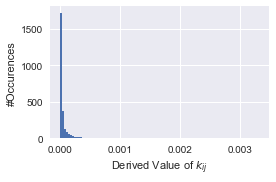

Using median constant

RMSE:  157758.45355013653
MSE:  24887729666.53059
MAE:  24223.113641980668
MAPE:  9.05770965695887
MDAE:  407.2761755412025
mean error:  24223.113641980668
median error:  407.2761755412025

---------------------------------------------------
Using mean constant

RMSE:  140226.89164782315
MSE:  19663581141.21034
MAE:  22324.95875272411
MAPE:  49.18680740199723
MDAE:  2115.5781501020115
mean error:  22324.958752724113
median error:  2115.5781501020115

---------------------------------------------------
Using 1

RMSE:  383985573.8918764
MSE:  1.4744492095707366e+17
MAE:  83655739.10560976
MAPE:  532334.8421009737
MDAE:  30237107.95179487
mean error:  83655739.10560976
median error:  30237107.95179487

---------------------------------------------------


In [48]:
test('Distance(minutes)');

## Distance in minutes squared

weights min/max:  1 / 2785260
median constant:  0.0015780262380865658
mean constant:  0.005012188621713835
min/max constant:  1.1468431075626477e-06 / 0.21056210114252036
-----------------------------------------



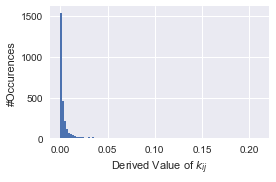

Using median constant

RMSE:  160894.51827130356
MSE:  25887046009.754833
MAE:  23157.599432705392
MAPE:  7.503752909263288
MDAE:  392.9156433389779
mean error:  23157.599432705392
median error:  392.9156433389779

---------------------------------------------------
Using mean constant

RMSE:  371061.47931257903
MSE:  137686621429.63953
MAE:  26974.560080272277
MAPE:  24.341579604212384
MDAE:  1048.2612630104427
mean error:  26974.560080272273
median error:  1048.2612630104427

---------------------------------------------------
Using 1

RMSE:  80887583.16806014
MSE:  6542801110769847.0
MAE:  4519256.703929442
MAPE:  5009.763701715675
MDAE:  315095.84748545696
mean error:  4519256.703929441
median error:  315095.84748545696

---------------------------------------------------


In [49]:
test('Distance(minutes)', power=2)

## Distance in kilometers

weights min/max:  1 / 2785260
median constant:  2.4449218990158516e-05
mean constant:  0.00011720271760787699
min/max constant:  3.3201669877109445e-08 / 0.0043428433360644825
-----------------------------------------



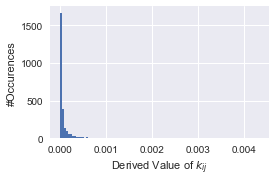

Using median constant

RMSE:  155068.76237609377
MSE:  24046321064.85344
MAE:  23947.46242973989
MAPE:  9.050090215943317
MDAE:  417.55790868928204
mean error:  23947.462429739895
median error:  417.55790868928204

---------------------------------------------------
Using mean constant

RMSE:  133694.03805705046
MSE:  17874095812.000057
MAE:  21457.961514439696
MAPE:  44.30068873714054
MDAE:  1794.6554392571384
mean error:  21457.961514439696
median error:  1794.6554392571384

---------------------------------------------------
Using 1

RMSE:  484963976.8295227
MSE:  2.3519005882230586e+17
MAE:  74118591.83634783
MAPE:  384684.18603369675
MDAE:  21336354.484149195
mean error:  74118591.83634782
median error:  21336354.484149195

---------------------------------------------------


In [51]:
test('Distance(km)')

## Distance in kilometers squared

weights min/max:  1 / 2785260
median constant:  0.003129828616171929
mean constant:  0.010393117812853958
min/max constant:  1.6303494472895038e-06 / 0.5732553203605117
-----------------------------------------



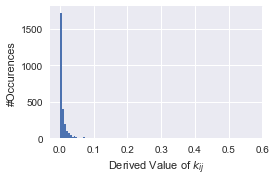

Using median constant

RMSE:  415368.3079067148
MSE:  172530831213.28745
MAE:  28242.379153090005
MAPE:  9.544216578460063
MDAE:  444.58276473025654
mean error:  28242.379153090005
median error:  444.58276473025654

---------------------------------------------------
Using mean constant

RMSE:  1436455.313531722
MSE:  2063403867773.5178
MAE:  57225.53576630097
MAPE:  32.2126127259075
MDAE:  1066.1847785347218
mean error:  57225.53576630098
median error:  1066.1847785347218

---------------------------------------------------
Using 1

RMSE:  143307367.37671378
MSE:  2.0537001544444412e+16
MAE:  5990145.943580223
MAPE:  3172.8338272455885
MDAE:  144414.8043187935
mean error:  5990145.943580223
median error:  144414.8043187935

---------------------------------------------------


In [52]:
test('Distance(km)', power=2)

# Generating the new edges using best parameters

Identifying the nodes which were not connected in the network

In [18]:
missing = [node for node in G.nodes if G.degree[node] == 0]
c = get_constant(attribute='Distance(minutes)',power=2, detail=False)[1]

len(missing)

weights min/max:  1.0 / 2785260.0


19

In [53]:
def calculate_w(origin, destination, constant):
    if (origin, destination) in distance_dict:
        distance = distance_dict[(origin, destination)]['Distance(minutes)'] **2
        pop_origin = G.nodes[origin]['Population size']
        pop_destination = G.nodes[destination]['Population size']
        w = constant * ((pop_origin*pop_destination) / distance)
        return w
    else: 
        return None
    
def generate_edges(constant):
    c = 0
    print(len(G.nodes))
    for muni1 in missing:
        for muni2 in G.nodes:
            if muni1 != muni2:
                fake_weight = calculate_w(muni1, muni2, constant)
                if fake_weight != None:
                    G.add_edge(muni1, muni2, weight = round(fake_weight))
                    c += 1
    print('Total edges added: ', c)
    return G

In [20]:
H = generate_edges(c)


H['Nordfyns']

98
Total edges added:  1501


AtlasView({'Aabenraa': {'weight': 464}, 'Aalborg': {'weight': 464}, 'Aarhus': {'weight': 2215}, 'Assens': {'weight': 991}, 'Brønderslev': {'weight': 62}, 'København': {'weight': 1673}, 'Esbjerg': {'weight': 804}, 'Faaborg-Midtfyn': {'weight': 1192}, 'Favrskov': {'weight': 268}, 'Faxe': {'weight': 106}, 'Fredensborg': {'weight': 81}, 'Fredericia': {'weight': 1666}, 'Frederikshavn': {'weight': 83}, 'Gentofte': {'weight': 189}, 'Guldborgsund': {'weight': 117}, 'Haderslev': {'weight': 636}, 'Hedensted': {'weight': 697}, 'Helsingør': {'weight': 116}, 'Herning': {'weight': 539}, 'Hjørring': {'weight': 94}, 'Holbæk': {'weight': 249}, 'Holstebro': {'weight': 223}, 'Horsens': {'weight': 1008}, 'Høje-Taastrup': {'weight': 160}, 'Hørsholm': {'weight': 57}, 'Ikast-Brande': {'weight': 234}, 'Kalundborg': {'weight': 187}, 'Kerteminde': {'weight': 429}, 'Kolding': {'weight': 2061}, 'Køge': {'weight': 240}, 'Lejre': {'weight': 101}, 'Lolland': {'weight': 86}, 'Mariagerfjord': {'weight': 136}, 'Middelf

### Removing self-loops

In [22]:
H.remove_edges_from(nx.selfloop_edges(H))

In [23]:
list(nx.selfloop_edges(H))

[]

In [24]:
nx.write_gpickle(H, "networks/gravityNoselfloops.gpickle")

In [25]:
nx.write_weighted_edgelist(H, "networks/gravityNoselfloops.edgelist")

In [26]:
!head networks/gravityNoselfloops.edgelist

Aabenraa Aalborg 1934.0
Aabenraa Aarhus 12247.0
Aabenraa Assens 178.0
Aabenraa Brønderslev 229.0
Aabenraa København 32240.0
Aabenraa Esbjerg 3336.0
Aabenraa Faaborg-Midtfyn 173.0
Aabenraa Favrskov 422.0
Aabenraa Faxe 18.0
Aabenraa Fredensborg 96.0


In [54]:
print(nx.info(H))

Name: 
Type: Graph
Number of nodes: 98
Number of edges: 4191
Average degree:  85.5306
